# 4 - 1D Rayleigh wave phase velocity inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/3_electrical_resistivity_tomography.ipynb)

---

## What we do in this notebook

Here we look at applying CoFI to an Rayleigh wave surface wave dispersion problem.

**Learning outcomes**

- A demonstration of CoFI's ability to switch between parameter estimation and ensemble methods.
- A comparison between different McMC samplers that is fixed-d and trans-d samplers
- An application of CoFI to field data


In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi git+https://github.com/miili/pysurf96.git

## Problem description

There are two types of surface waves that travel along the surface of the earth Love and Rayleigh waves. The depth to which these waves penetrate is a function of the wave type and wavelength; thus the velocity at which they travel becomes a function of wavelenght. If velocity changes with depth, as is the case in the Earth, we observe what is known as surface wave dispersion. For a constant velocity half space no dispersion would occur. Thus surface wave dispersion offers a way to probe the earth, with dispersion measurements typically obtained thorugh a spectral analysis of the observed timeseries. Applications span a wide range of scales from imaging the mantle to recovering paleochannel networks.

Here we illustrate the flexibility of CoFI by after defining the base problem using first an iterative non linear apporach to find the maximum a posterior solution and then a range of Markov Chain Monte Carlo methods to sample the posterior distribution. The forward problem is solved using pysurf 96 (https://github.com/miili/pysurf96) and the field data example is taken from  (https://www.eas.slu.edu/eqc/eqc_cps/TUTORIAL/STRUCT/index.html) and we will be inverting observed rayleigh wave phase velocities


The objective function we are minimizing with parameter estimation is given as:

$$
\Psi(\mathbf{m}) = (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} + \lambda \mathbf{m}^{T} W^{\mathrm{T}} W \mathbf{{m}},
$$

where $\mathbf{d}$ represents the data vector of measured phase velocities, $\mathrm{f}(\mathbf{m})$ is the model prediction, $C_d^{-1}$ is the inverse of the data covariance matrix, $W$ the model smoothing matrix, $\mathbf{m}$ the model vector and $\lambda$ a regularization factor. The model update is then given as

$$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}+\lambda W^{T} W}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{d}-\mathrm{f}(\mathbf{m}))+\lambda W^{T} W \mathbf{m}}_{\mathbf{Gradient}}),
\end{equation} 
$$

where $J$ represents the Jacobian.

The Log Likelihood function we will be sampling with various ensemble methods is given as:


**Further reading**

https://en.wikipedia.org/wiki/Surface_wave_inversion

## Utilities preparation

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from pysurf96 import surf96
import bayesbay
import cofi

In [3]:
np.seterr(all="ignore");

**1. Model vector**

We use the so-called "layer cake" parameterisation throughout the whole notebook. That means the model vector would look like:

```python
[velocity_1, thickness_1, velocity_2, thickness_2, velocity_3, ..., velocity_n]
```

Later for some samplers we may need to convert between layer cake and Voronoi parameterisations, where the model vector would instead look like:

```python
[velocity_1, velocity_2, ..., velocity_n, voronoi_site_1, voronoi_site_2, ..., voronoi_site_n]
```

Hence the following utilities are prepared.

In [4]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

In [5]:
# voronoi model utilities
def form_voronoi_model(voronoi_sites, vs):
    return np.hstack((vs, voronoi_sites))

def split_voronoi_model(model):
    voronoi_sites = model[len(model)//2:]
    vs = model[:len(model)//2]
    return voronoi_sites, vs

In [6]:
def voronoi_to_layercake(voronoi_vector: np.ndarray) -> np.ndarray:
    n_layers = len(voronoi_vector) // 2
    velocities = voronoi_vector[:n_layers]
    voronoi_sites = voronoi_vector[n_layers:]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    layercake_vector = np.zeros((2*n_layers-1,))
    layercake_vector[::2] = velocities
    layercake_vector[1::2] = thicknesses
    return layercake_vector

def layercake_to_voronoi(layercake_vector: np.ndarray, first_voronoi_site: float = 0.0) -> np.ndarray:
    n_layers = len(layercake_vector) // 2 + 1
    thicknesses = layercake_vector[1::2]
    velocities = layercake_vector[::2]
    depths = np.cumsum(thicknesses)
    voronoi_sites = np.zeros((n_layers,))
    for i in range(1,len(voronoi_sites)):
        voronoi_sites[i] = 2 * depths[i-1] - voronoi_sites[i-1]
    voronoi_vector = np.hstack((velocities, voronoi_sites))
    return voronoi_vector

**2. Interfacing to pysurf96**

We create two small utility functions that given Vp, Vs, rho and periods will return the Rayleigh wave phase velocity dispersion curve and a numerical Jacobian

In [7]:
# Constants
VP_VS = 1.77
RHO_VP_K = 0.32
RHO_VP_B = 0.77

In [8]:
# forward through pysurf96
def forward_sw(model, periods):
    thicknesses, vs = split_layercake_model(model)
    thicknesses = np.append(thicknesses, 10)
    vp = vs * VP_VS
    rho = RHO_VP_K * vp + RHO_VP_B
    return surf96(
        thicknesses,
        vp,
        vs,
        rho,
        periods,
        wave="rayleigh",
        mode=1,
        velocity="phase",
        flat_earth=False,
    )

# numerical jacobian
def jacobian_sw(model, periods, fwd=forward_sw, relative_step=0.01):
    jacobian = np.zeros((len(periods), len(model)))
    original_dpred = fwd(model, periods)
    for i in range(len(model)):
        perturbed_model = model.copy()
        step = relative_step * model[i]
        perturbed_model[i] += step
        perturbed_dpred = fwd(perturbed_model, periods)
        derivative = (perturbed_dpred - original_dpred) / step
        jacobian[:, i] = derivative
    return jacobian

**3. Plotting**

In [9]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [10]:
def plot_data(rayleigh_phase_velocities, periods, ax=None, scatter=False, 
              title="data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    if scatter:
        ax.scatter(periods, rayleigh_phase_velocities, **plotting_style)
    else:
        ax.plot(periods, rayleigh_phase_velocities, **plotting_style)
    ax.set_xlabel("Periods (s)")
    ax.set_ylabel("Rayleigh phase velocities (km/s)")
    ax.set_title(title)
    return ax

## Synthetic example

### Generate synthetic data

In [11]:
synth_d_periods = np.geomspace(3, 80, 20)

true_thicknesses = np.array([10, 10, 15, 20, 20, 20, 20, 20])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
true_model = form_layercake_model(true_thicknesses, true_vs)

In [12]:
noise_level = 0.02
d_true = forward_sw(true_model, synth_d_periods)
d_obs = d_true + np.random.normal(0, 0.01, len(d_true))

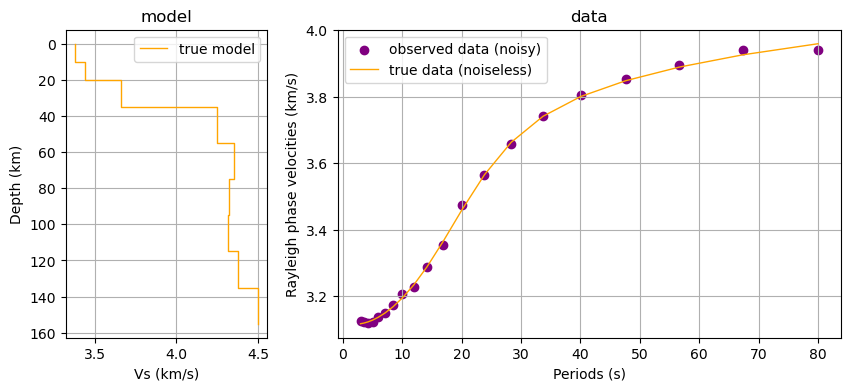

In [13]:
# plot true model and data

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 2.5]})

plot_model(true_model, ax=ax1, color="orange", alpha=1, lw=1, label="true model")
ax1.grid()
ax1.legend()

plot_data(d_obs, synth_d_periods, ax=ax2, color="purple", scatter=True, 
          label="observed data (noisy)")
plot_data(d_true, synth_d_periods, ax=ax2, color="orange", 
          label="true data (noiseless)")
ax2.grid()
ax2.legend();

### Optimisation

**Prepare `BaseProblem` for optimisation**

In [14]:
n_dims = 17

init_thicknesses = np.ones((n_dims//2,)) * 15
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

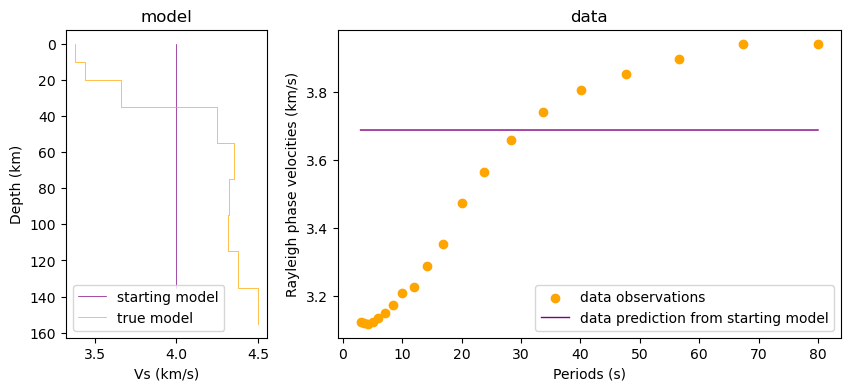

In [15]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

plot_model(init_model, ax=ax1, label="starting model", alpha=1, color="purple")
plot_model(true_model, ax=ax1, label="true model", alpha=1, color="orange")

plot_data(d_obs, synth_d_periods, ax=ax2, color="orange", scatter=True, 
          label="data observations")
plot_data(forward_sw(init_model, synth_d_periods), synth_d_periods, ax=ax2, 
          label="data prediction from starting model", color="purple")

ax1.legend()
ax2.legend();

In [16]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

In [17]:
def my_objective(model, fwd, periods, d_obs, lamda=1.0):
    d_pred = fwd(model, periods)
    data_misfit = np.sum((d_obs - d_pred) ** 2)
    reg = my_reg(model)
    return data_misfit + lamda * reg

def my_objective_gradient(model, fwd, periods, d_obs, lamda=1.0):
    d_pred = fwd(model, periods)
    jac = jacobian_sw(model, periods, fwd)
    data_misfit_grad = -2 * jac.T @ (d_obs - d_pred)
    reg_grad = my_reg.gradient(model)
    return data_misfit_grad + lamda * reg_grad

def my_objective_hessian(model, fwd, periods, d_obs, lamda=1.0):
    jac = jacobian_sw(model, periods, fwd)
    data_misfit_hess = 2 * jac.T @ jac
    reg_hess = my_reg.hessian(model)
    return data_misfit_hess + lamda * reg_hess

#### Optimisation with no damping

In [18]:
lamda = 0

kwargs = {
    "fwd": forward_sw, 
    "periods": synth_d_periods, 
    "d_obs": d_obs, 
    "lamda": lamda
}
sw_problem_no_reg = cofi.BaseProblem()
sw_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
sw_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_problem_no_reg.set_initial_model(init_model)

**Define `InversionOptions`**

In [19]:
inv_options_optimiser = cofi.InversionOptions()
inv_options_optimiser.set_tool("scipy.optimize.minimize")
inv_options_optimiser.set_params(method="trust-exact")

**Define `Inversion` and run**

In [20]:
inv_optimiser_no_reg = cofi.Inversion(sw_problem_no_reg, inv_options_optimiser)
inv_result_optimiser_no_reg = inv_optimiser_no_reg.run()

/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


**Plot results**

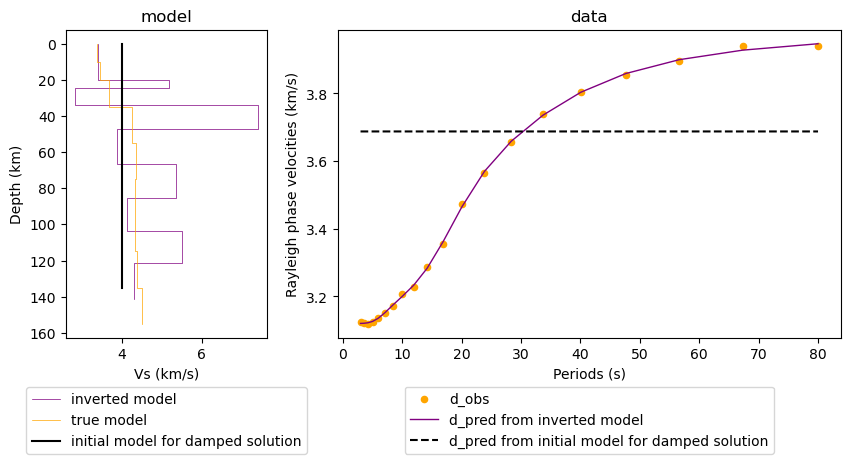

In [21]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

plot_model(inv_result_optimiser_no_reg.model, ax=ax1, color="purple", alpha=1, 
           label="inverted model")
plot_model(true_model, ax=ax1, color="orange", alpha=1, label="true model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")

plot_data(d_obs, synth_d_periods, ax=ax2, color="orange", s=20, scatter=True, 
          label="d_obs")
plot_data(forward_sw(inv_result_optimiser_no_reg.model, synth_d_periods), 
          synth_d_periods, ax=ax2, color="purple", 
          label="d_pred from inverted model")
plot_data(forward_sw(init_model, synth_d_periods), synth_d_periods, ax=ax2, 
          alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4));

#### Optimal damping

Obviously we get a very skewed 1D model out of an optimisation that solely tries
to minimise the data misfit. We would like to add a damping term to our objective
function, but we are not sure which factor suits the problem well.

In this situation, the `InversionPool` from CoFI can be handy.

In [22]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd": forward_sw, 
        "periods": synth_d_periods, 
        "d_obs": d_obs, 
        "lamda": lamb
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = np.linalg.norm(forward_sw(m, synth_d_periods) - d_obs)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 0.025298043674203748, 5.273688158534549
Finished inversion with lambda=7.196856730011514e-06: 0.026286960249292304, 2.548902725706329
Finished inversion with lambda=5.1794746792312125e-05: 0.027718968598188787, 1.66749417064743
Finished inversion with lambda=0.0003727593720314938: 0.030422446873507345, 1.2289788308847758
Finished inversion with lambda=0.0026826957952797246: 0.03265586443325113, 1.161398402018167
Finished inversion with lambda=0.019306977288832496: 0.04476117975901857, 1.1191702340192786
Finished inversion with lambda=0.1389495494373136: 0.152815038695487, 0.9780532434368032
Finished inversion with lambda=1.0: 0.4996199136075679, 0.6561964250840591
Finished inversion with lambda=7.196856730011514: 1.0976277248052961, 0.31267435986741415
Finished inversion with lambda=51.79474679231202: 1.6212309920208723, 0.06747965935067801
Finished inversion with lambda=372.7593720314938: 1.7457940322905163, 0.010098593104774331
Finished inversion

In [23]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

**Plot L-curve**

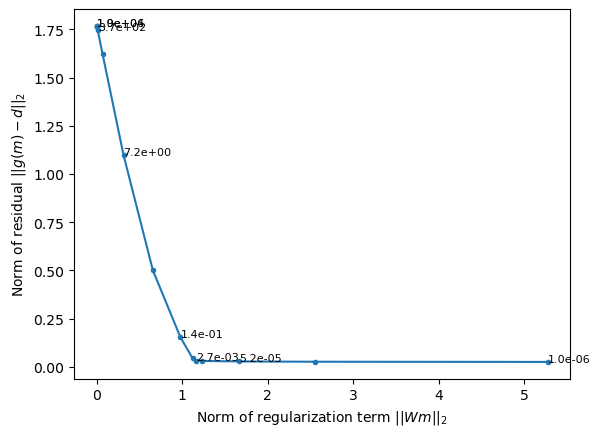

In [24]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

#### Optimisation with damping

From the L-curve plot above, it seems that a damping factor of around 0.02 would be 
good.

In [25]:
lamda = 0.02

kwargs = {
    "fwd": forward_sw, 
    "periods": synth_d_periods, 
    "d_obs": d_obs, 
    "lamda": lamda
}
sw_problem = cofi.BaseProblem()
sw_problem.set_objective(my_objective, kwargs=kwargs)
sw_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [26]:
inv_optimiser = cofi.Inversion(sw_problem, inv_options_optimiser)
inv_result_optimiser = inv_optimiser.run()

**Plot results**

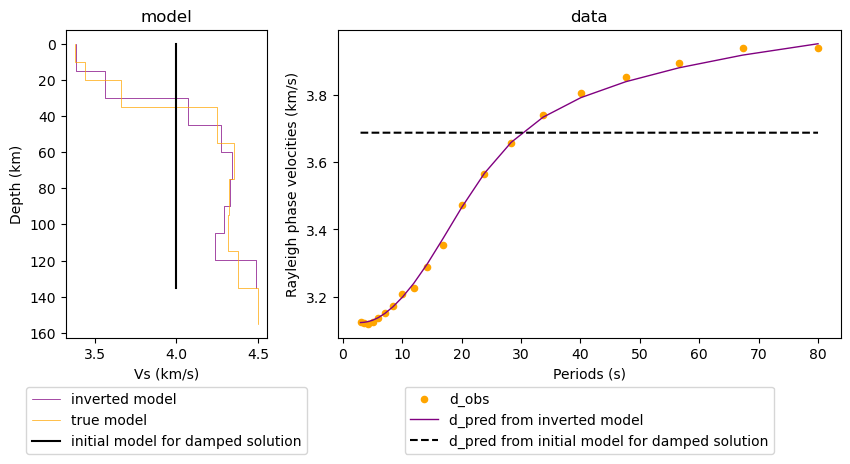

In [27]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

plot_model(inv_result_optimiser.model, ax=ax1, color="purple", alpha=1, 
           label="inverted model")
plot_model(true_model, ax=ax1, color="orange", alpha=1, label="true model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")

plot_data(d_obs, synth_d_periods, ax=ax2, color="orange", s=20, scatter=True, 
          label="d_obs")
plot_data(forward_sw(inv_result_optimiser.model, synth_d_periods), synth_d_periods, 
          ax=ax2, color="purple", label="d_pred from inverted model")
plot_data(forward_sw(init_model, synth_d_periods), synth_d_periods, ax=ax2, 
          alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4));

### Fixed-dimensional sampling

**Prepare `BaseProblem` for fixed-dimensional sampling**

In [28]:
thick_min = 5
thick_max = 30
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < 2) | (vs > 5)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = -np.log(30 - 5) * len(thicknesses) - np.log(5 - 2) * len(vs)
    return log_prior

In [29]:
Cdinv = np.eye(len(d_obs))/(noise_level**2)      # inverse data covariance matrix

def my_log_likelihood(model):
    try:
        d_pred = forward_sw(model, synth_d_periods)
    except:
        return float("-inf")
    residual = d_obs - d_pred
    return -0.5 * residual @ (Cdinv @ residual).T

In [30]:
n_walkers = 40

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_result_optimiser.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.5, n_dims)

In [31]:
sw_problem.set_log_prior(my_log_prior)
sw_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [32]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers, 
    nsteps=2_000, 
    initial_state=my_walkers_start, 
    skip_initial_state_check=True, 
    progress=True
)

**Define `Inversion` and run**

#### Sample the prior

In [33]:
prior_sampling_problem = cofi.BaseProblem()
prior_sampling_problem.set_log_posterior(my_log_prior)
prior_sampling_problem.set_model_shape(init_model.shape)
prior_sampler = cofi.Inversion(prior_sampling_problem, inv_options_fixed_d_sampling)
prior_results = prior_sampler.run()

100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1108.63it/s]


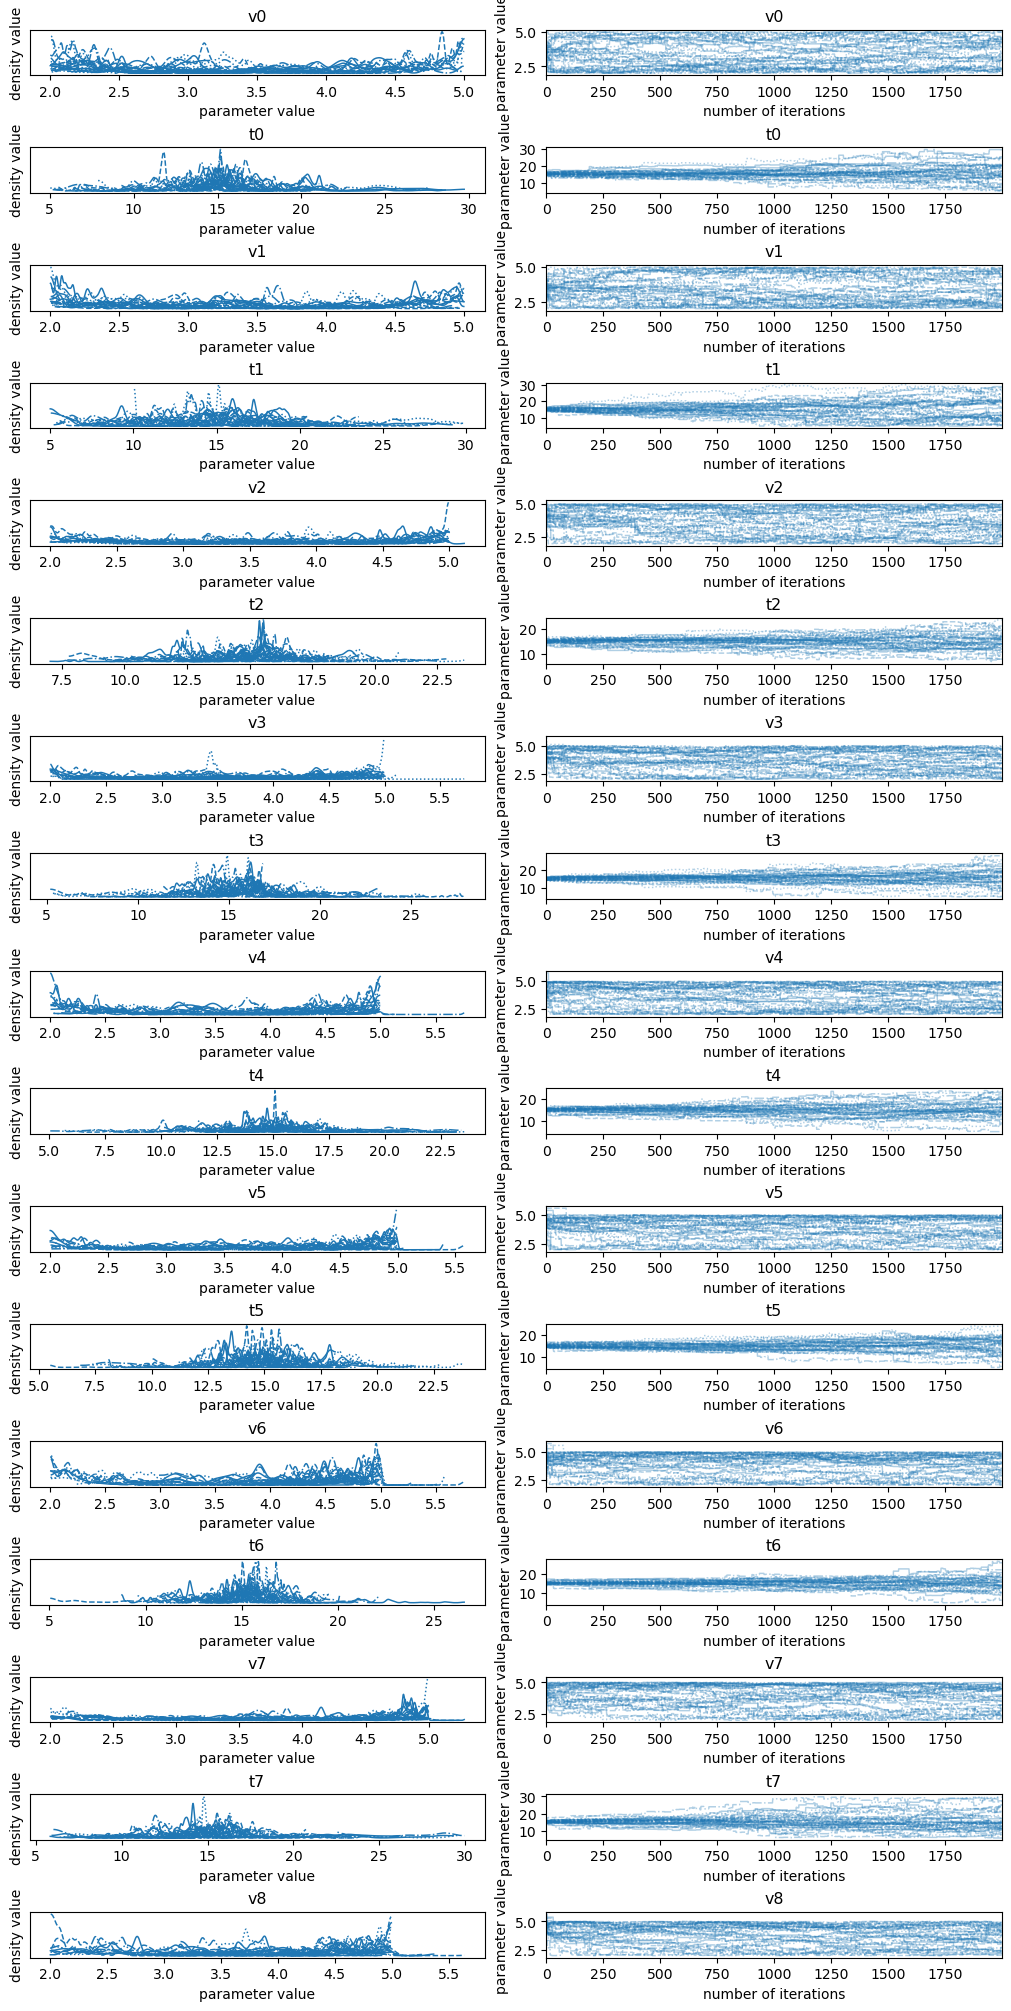

In [34]:
import arviz as az

labels = ["v0", "t0", "v1", "t1", "v2", "t2", "v3", "t3", "v4", "t4", "v5", "t5", "v6", "t6", "v7", "t7", "v8"]

prior_results_sampler = prior_results.sampler
az_idata_prior = az.from_emcee(prior_results_sampler, var_names=labels)

axes = az.plot_trace(
    az_idata_prior, 
    backend_kwargs={"constrained_layout":True}, 
    figsize=(10,20),
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

#### Sample the posterior

In [35]:
inversion_fixed_d_sampler = cofi.Inversion(sw_problem, inv_options_fixed_d_sampling)
inv_result_fixed_d_sampler = inversion_fixed_d_sampler.run()

100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.17it/s]


In [36]:
sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [37]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables: (12/17)
    v0       (chain, draw) float64 2.987 2.988 2.988 2.988 ... 3.409 3.409 3.409
    t0       (chain, draw) float64 16.01 15.77 15.77 15.77 ... 25.59 25.59 25.59
    v1       (chain, draw) float64 3.175 3.283 3.283 3.283 ... 4.022 4.022 4.022
    t1       (chain, draw) float64 14.86 14.87 14.87 14.87 ... 28.73 28.73 28.73
    v2       (chain, draw) float64 4.038 4.051 4.051 4.051 ... 4.449 4.449 4.449
    t2       (chain, draw) float64 14.76 14.87 14.87 14.87 ... 12.29 12.29 12.29
    ...       ...
    t5       (chain, draw) float64 15.08 15.02 15.02 15.02 ... 23.81 23.81 23.81
    v6       (chain, draw) float64 4.464 4.418 4.418 4.418 ... 3.378 3.378 3.378
    t6       (chain, draw) float64 14.89 14.95 14.95 14.95 ... 15.05 15.05 15.05
    v7       (chain, draw) float64 4.413 4.527 4.527 4.527 ... 4.469 4.469 4.469
    t7       (chain, draw) float64 14.96 14.94 14.94 14.94 ... 11.05 11.05 11.05
    v8       (chain, draw) float64 4.29 4.338 4.338 4.338 ... 4.7 4.7 4.7 4.7
Attributes:
    created_at:                 2024-03-25T01:18:41.855057
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

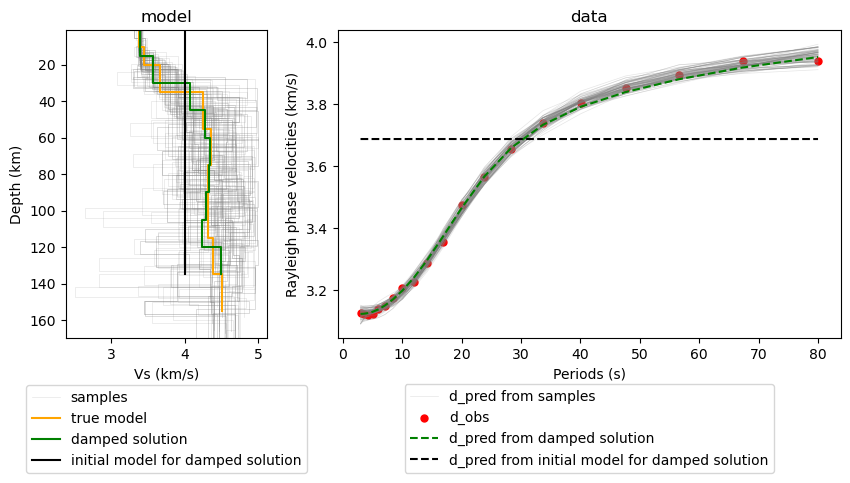

In [38]:
flat_samples = sampler.get_chain(discard=500, thin=500, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(170)

# plot samples and data predictions from samples
for idx in rand_indices:
    sample = flat_samples[idx]
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_data(forward_sw(sample, synth_d_periods), synth_d_periods, 
              ax=ax2, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
plot_model(flat_samples[rand_indices[0]], ax=ax1, alpha=0.2, lw=0.5, 
           color="gray", label="samples")
plot_data(forward_sw(flat_samples[rand_indices[0]], synth_d_periods), 
          synth_d_periods, ax=ax2, alpha=0.2, lw=0.5, color="gray", 
          label="d_pred from samples")

# plot true model and data observations
plot_model(true_model, ax=ax1, alpha=1, lw=1.5, color="orange", label="true model")
plot_data(d_obs, synth_d_periods, ax=ax2, s=25, scatter=True, color="red", 
          label="d_obs")

# plot damped optimisation result
plot_model(inv_result_optimiser.model, ax=ax1, alpha=1, lw=1.5, color="green", label="damped solution")
plot_data(forward_sw(inv_result_optimiser.model, synth_d_periods), 
          synth_d_periods, ax=ax2, alpha=1, lw=1.5, linestyle="--", color="green", 
          label="d_pred from damped solution")

# plot initial model for damped optimisation
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")
plot_data(forward_sw(init_model, synth_d_periods), synth_d_periods, 
          ax=ax2, alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

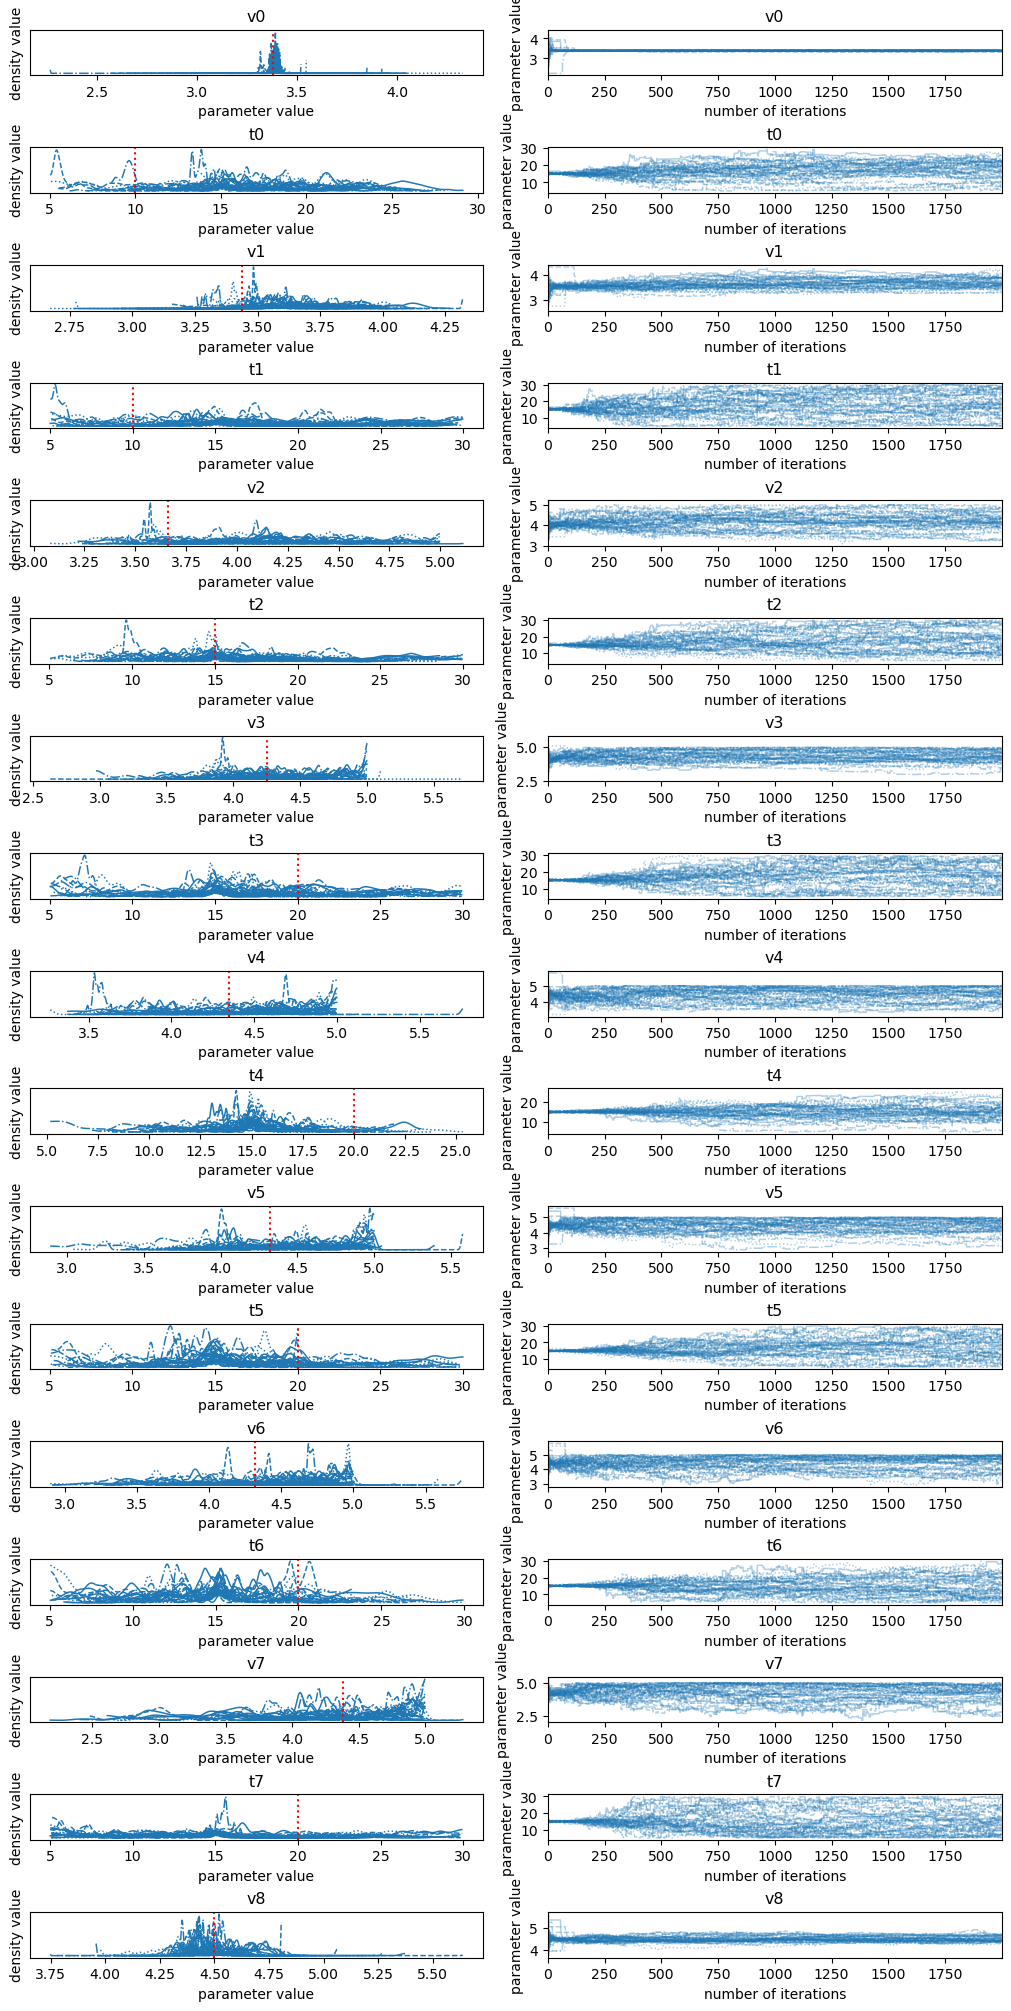

In [39]:
axes = az.plot_trace(
    az_idata, 
    backend_kwargs={"constrained_layout":True},
    figsize=(10,20)
)

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

**More steps?**

Due to time restrictions, we have only run 2_000 steps above, which might be
enough for illustration purpose and sanity check, but are not enough for an actual
inversion.

On a seperate experiment, we ran 200_000 steps instead and produced the following
samples plot.

![Fixed-dimensional sampling results with 200_000 steps](emcee_200_000_iterations.png)

### Trans-dimensional sampling

**Prepare utilities for trans-dimensional sampling**

In [40]:
def forward_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw(model, synth_d_periods)

In [41]:
targets = [bayesbay.Target("rayleigh", d_obs, covariance_mat_inv=1/noise_level**2)]
fwd_funcs = [forward_for_bayesbay]
my_log_likelihood = bayesbay.LogLikelihood(targets, fwd_funcs)

In [42]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [43]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=15, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [44]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [45]:
inv_options_trans_d_sampling = cofi.InversionOptions()
inv_options_trans_d_sampling.set_tool("bayesbay")
inv_options_trans_d_sampling.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=3_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [46]:
inversion_trans_d_sampler = cofi.Inversion(sw_problem, inv_options_trans_d_sampling)
inv_result_trans_d_sampler = inversion_trans_d_sampler.run()

In [47]:
inverted_models = inv_result_trans_d_sampler.models
samples = []
for v, vs in zip(inverted_models["voronoi.discretization"], inverted_models["voronoi.vs"]):
    sample = form_voronoi_model(v, vs)
    samples.append(voronoi_to_layercake(sample))

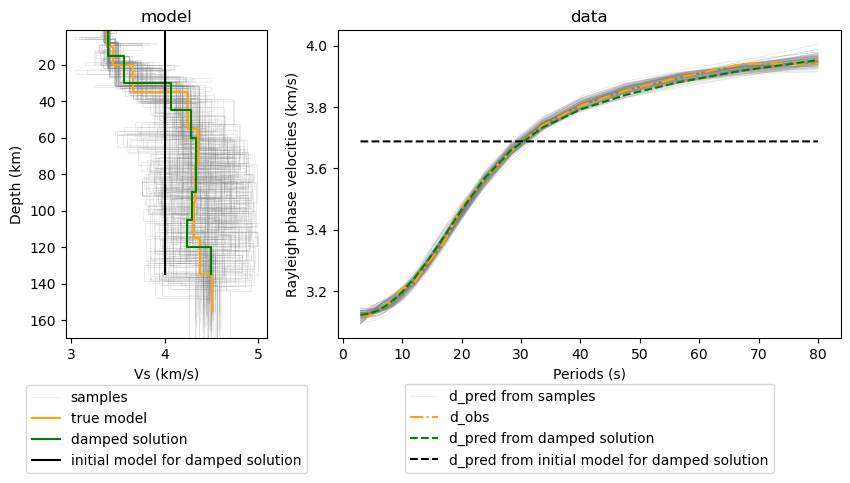

In [48]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(170)

for sample in samples:
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_data(forward_sw(sample, synth_d_periods), synth_d_periods, 
              ax=ax2, alpha=0.2, lw=0.5, color="gray")

# adding labels
plot_model(samples[0], ax=ax1, label="samples", alpha=0.2, lw=0.5, color="gray")
plot_data(forward_sw(samples[0], synth_d_periods), synth_d_periods, 
          ax=ax2, alpha=0.2, lw=0.5, color="gray", label="d_pred from samples")

plot_model(true_model, ax=ax1, alpha=1, lw=1.5, color="orange", label="true model")
plot_data(d_obs, synth_d_periods, ax=ax2, alpha=1, lw=1.5, 
          linestyle="-.", color="orange", label="d_obs")

plot_model(inv_result_optimiser.model, ax=ax1, alpha=1, lw=1.5, color="green", 
           label="damped solution")
plot_data(forward_sw(inv_result_optimiser.model, synth_d_periods), 
          synth_d_periods, ax=ax2, alpha=1, lw=1.5, linestyle="--", color="green", 
          label="d_pred from damped solution")

plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")
plot_data(forward_sw(init_model, synth_d_periods), synth_d_periods, 
          ax=ax2, alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

## Field data example

### Read data

**Rayleigh observations**

In [49]:
file_surf_data = "data/SURF/nnall.dsp"

with open(file_surf_data, "r") as file:
    lines = file.readlines()
    surf_data = []
    for line in lines:
        row = line.strip().split()
        if "C" in row:
            surf_data.append([float(e) for e in row[5:8]])

field_d = np.array(surf_data)
field_d_periods = field_d[:,0]
field_d_obs = field_d[:,1]

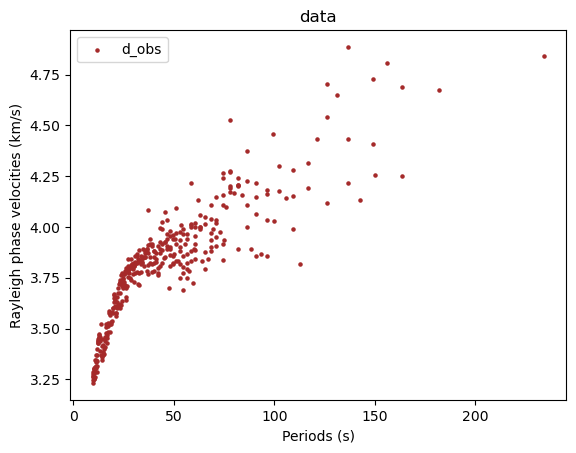

In [50]:
ax = plot_data(field_d_obs, field_d_periods, color="brown", s=5, scatter=True,
             label="d_obs")
ax.legend();

**Reference good model**

In [51]:
file_end_mod = "data/SURF/end.mod"

with open(file_end_mod, "r") as file:
    lines = file.readlines()
    ref_good_model = []
    for line in lines[12:]:
        row = line.strip().split()
        ref_good_model.append([float(row[0]), float(row[2])])

ref_good_model = np.array(ref_good_model)
ref_good_model = form_layercake_model(ref_good_model[:-1,0], ref_good_model[:,1])

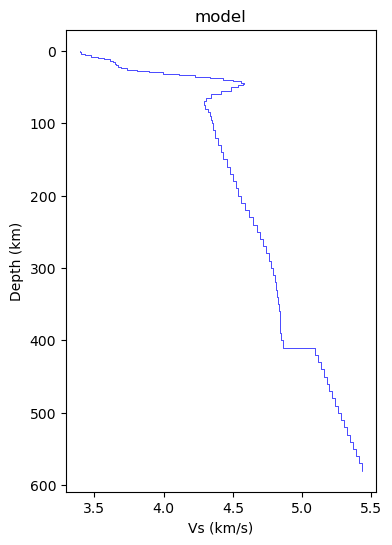

In [52]:
_, ax = plt.subplots(figsize=(4,6))
plot_model(ref_good_model, ax=ax, alpha=1);

### Modified forward utility

In [53]:
def forward_sw_interp(model, periods=field_d_periods):
    pysurf_periods = np.logspace(
        np.log(np.min(periods)), 
        np.log(np.max(periods+1)), 
        60,
        base=np.e, 
    )
    pysurf_dpred = forward_sw(model, pysurf_periods)
    interp_func = scipy.interpolate.interp1d(pysurf_periods, 
                                             pysurf_dpred, 
                                             fill_value="extrapolate")
    dpred = interp_func(periods)
    return dpred

### Optimisation

In [54]:
n_dims = 29

init_thicknesses = np.ones((n_dims//2,)) * 10
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

In [55]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

#### Optimisation with no damping

In [56]:
lamda = 0

kwargs = {
    "fwd": forward_sw_interp,
    "periods": field_d_periods, 
    "d_obs": field_d_obs, 
    "lamda": lamda, 
}
sw_field_problem_no_reg = cofi.BaseProblem()
sw_field_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
sw_field_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_field_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_field_problem_no_reg.set_initial_model(init_model)

**Define `Inversion` and run**

In [57]:
inv_sw_field_problem_no_reg = cofi.Inversion(sw_field_problem_no_reg, inv_options_optimiser)
inv_result_sw_field_no_reg = inv_sw_field_problem_no_reg.run()

/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


In [58]:
inv_result_sw_field_no_reg.model

array([ 3.24208803, 18.13313122,  7.67417107,  6.31648707,  2.93215212,
       10.4135171 ,  7.85134594, 11.23626511,  5.05456665, 18.02780639,
        6.7759865 , 13.51309794,  1.49494382,  5.87527678,  5.26153426,
       13.6228779 ,  8.70552538, 13.41571772, 12.12688196, 13.96877989,
       11.91787495, 13.12535301, 11.31525638,  7.81538455,  3.76419121,
        9.02294837,  3.11943633,  9.96607716,  5.6513451 ])

**Plot results**

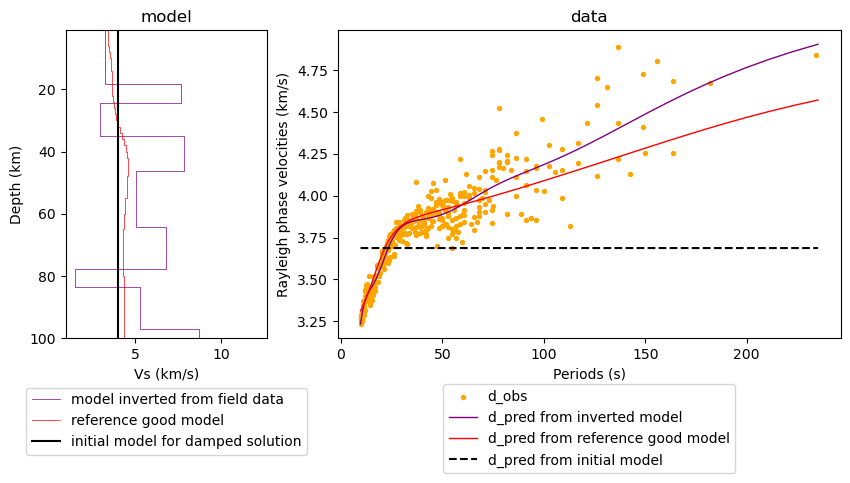

In [59]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

plot_model(inv_result_sw_field_no_reg.model, ax=ax1, color="purple", alpha=1, 
           label="model inverted from field data")
plot_model(ref_good_model, ax=ax1, color="red", alpha=1, 
           label="reference good model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")

field_d_periods_logspace = np.logspace(
    np.log(np.min(field_d_periods)), 
    np.log(np.max(field_d_periods+1)), 
    60, 
    base=np.e, 
)

plot_data(field_d_obs, field_d_periods, ax=ax2, color="orange", s=8, scatter=True, 
          label="d_obs")
plot_data(forward_sw_interp(inv_result_sw_field_no_reg.model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, color="purple", 
          label="d_pred from inverted model")
plot_data(forward_sw_interp(ref_good_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="red", 
             label="d_pred from reference good model")
plot_data(forward_sw_interp(init_model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, 
          alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

#### Optimal damping

Again, we would like to find a good regularisation factor.

In [60]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd": forward_sw_interp,
        "periods": field_d_periods, 
        "d_obs": field_d_obs, 
        "lamda": lamb, 
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = np.linalg.norm(forward_sw_interp(m, field_d_periods) - field_d_obs)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 1.9541990490401067, 26.344915306571828
Finished inversion with lambda=7.196856730011514e-06: 1.9553224319271587, 21.28568824550561
Finished inversion with lambda=5.1794746792312125e-05: 1.9674089962897339, 10.740245919864481
Finished inversion with lambda=0.0003727593720314938: 1.9698991462825037, 7.647768305345091
Finished inversion with lambda=0.0026826957952797246: 1.9782440845733156, 4.551629520495997
Finished inversion with lambda=0.019306977288832496: 2.0050549438091747, 2.3442273803058176
Finished inversion with lambda=0.1389495494373136: 2.0393073369018655, 1.6477206878151607
Finished inversion with lambda=1.0: 2.112939266124699, 1.3870331002558798
Finished inversion with lambda=7.196856730011514: 2.7878693578372693, 0.990760151448259
Finished inversion with lambda=51.79474679231202: 4.890126438918003, 0.34475194170977674
Finished inversion with lambda=372.7593720314938: 5.957321022746526, 0.06129962536156985
Finished inversion with lambda=

In [61]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

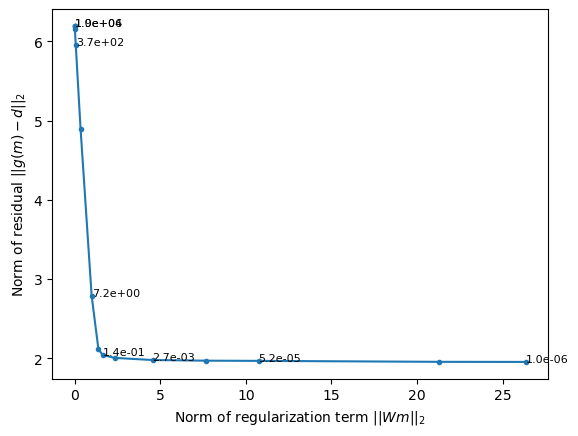

In [62]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

#### Optimisation with damping

In [63]:
lamda = 0.14

kwargs = {
    "fwd": forward_sw_interp,
    "periods": field_d_periods, 
    "d_obs": field_d_obs, 
    "lamda": lamda, 
}
sw_field_problem = cofi.BaseProblem()
sw_field_problem.set_objective(my_objective, kwargs=kwargs)
sw_field_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
sw_field_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
sw_field_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [64]:
inv_sw_field_problem = cofi.Inversion(sw_field_problem, inv_options_optimiser)
inv_result_sw_field = inv_sw_field_problem.run()

**Plot results**

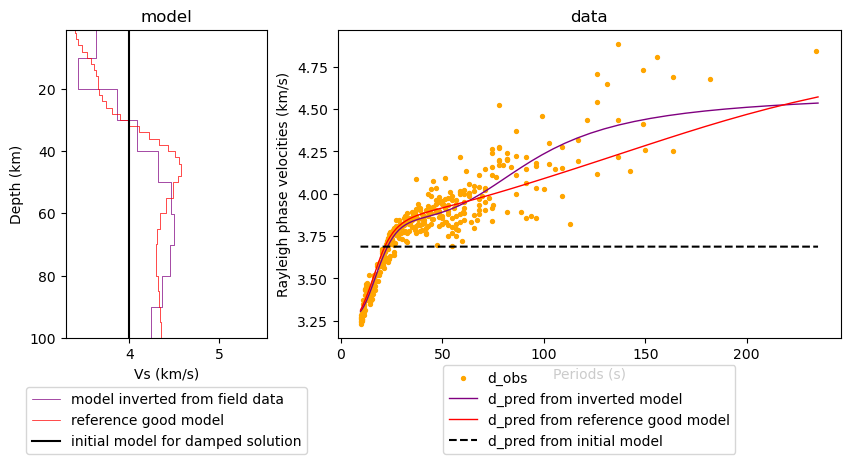

In [65]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

plot_model(inv_result_sw_field.model, ax=ax1, color="purple", alpha=1, 
           label="model inverted from field data")
plot_model(ref_good_model, ax=ax1, color="red", alpha=1, 
           label="reference good model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")

field_d_periods_logspace = np.logspace(
    np.log(np.min(field_d_periods)), 
    np.log(np.max(field_d_periods+1)), 
    60, 
    base=np.e, 
)

plot_data(field_d_obs, field_d_periods, ax=ax2, color="orange", s=8, scatter=True, 
          label="d_obs")
plot_data(forward_sw_interp(inv_result_sw_field.model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, color="purple", 
          label="d_pred from inverted model")
plot_data(forward_sw_interp(ref_good_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="red", 
             label="d_pred from reference good model")
plot_data(forward_sw_interp(init_model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, 
          alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4));

### Fixed-dimensional sampling

We are going to use the same sets of log prior, and we will rewrite the log likelihood
function to apply on the field data.

In [66]:
thick_min = 3
thick_max = 10
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < vs_min) | (vs > vs_max)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = - np.log(thick_max - thick_min) * len(thicknesses) \
                - np.log(vs_max - vs_min) * len(vs)
    return log_prior

In [67]:
# estimate the data noise
d_pred_from_optimiser = forward_sw_interp(inv_result_sw_field.model, field_d_periods)
noise_level = np.std(field_d_obs - d_pred_from_optimiser)
Cdinv = np.eye(len(field_d_obs))/(noise_level**2)

print(f"Estimated noise level: {noise_level}")

Estimated noise level: 0.10587785944399025


In [68]:
def my_log_likelihood(model):
    try:
        d_pred = forward_sw_interp(model, field_d_periods)
    except:
        return float("-inf")
    residual = field_d_obs - d_pred
    return -0.5 * residual @ (Cdinv @ residual).T

In [69]:
n_walkers = 60

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_result_sw_field.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.5, n_dims)

In [70]:
sw_field_problem.set_log_prior(my_log_prior)
sw_field_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [71]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers,
    nsteps=20_000,
    initial_state=my_walkers_start,
    skip_initial_state_check=True,
    progress=True
)

#### Sample the posterior

In [72]:
inversion_fixed_d_sampler_field = cofi.Inversion(sw_field_problem,
                                                 inv_options_fixed_d_sampling)
inv_result_fixed_d_sampler_field = inversion_fixed_d_sampler_field.run()

100%|██████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 881.79it/s]


In [73]:
sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [74]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables: (12/17)
    v0       (chain, draw) float64 2.987 2.988 2.988 2.988 ... 3.409 3.409 3.409
    t0       (chain, draw) float64 16.01 15.77 15.77 15.77 ... 25.59 25.59 25.59
    v1       (chain, draw) float64 3.175 3.283 3.283 3.283 ... 4.022 4.022 4.022
    t1       (chain, draw) float64 14.86 14.87 14.87 14.87 ... 28.73 28.73 28.73
    v2       (chain, draw) float64 4.038 4.051 4.051 4.051 ... 4.449 4.449 4.449
    t2       (chain, draw) float64 14.76 14.87 14.87 14.87 ... 12.29 12.29 12.29
    ...       ...
    t5       (chain, draw) float64 15.08 15.02 15.02 15.02 ... 23.81 23.81 23.81
    v6       (chain, draw) float64 4.464 4.418 4.418 4.418 ... 3.378 3.378 3.378
    t6       (chain, draw) float64 14.89 14.95 14.95 14.95 ... 15.05 15.05 15.05
    v7       (chain, draw) float64 4.413 4.527 4.527 4.527 ... 4.469 4.469 4.469
    t7       (chain, draw) float64 14.96 14.94 14.94 14.94 ... 11.05 11.05 11.05
    v8       (chain, draw) float64 4.29 4.338 4.338 4.338 ... 4.7 4.7 4.7 4.7
Attributes:
    created_at:                 2024-03-25T01:21:10.077503
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

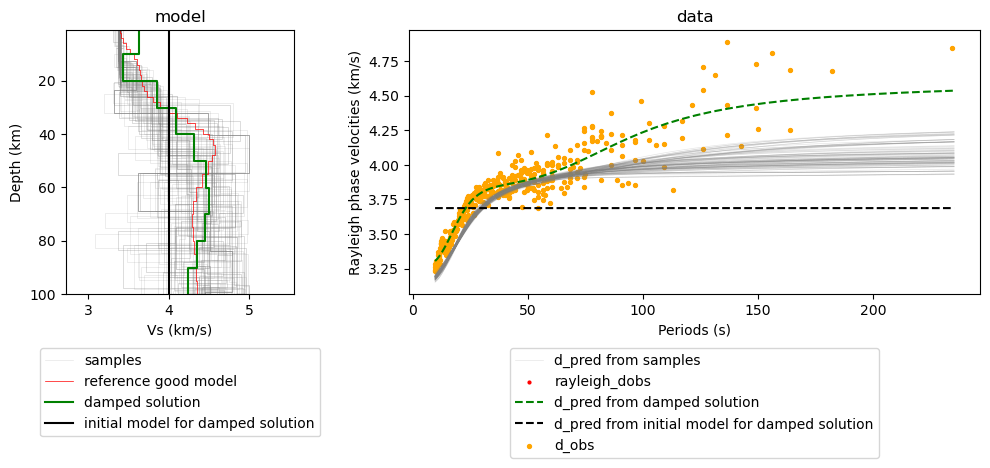

In [75]:
flat_samples = sampler.get_chain(discard=1000, thin=300, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

# plot samples and their predicted data
for idx in rand_indices:
    sample = flat_samples[idx]
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_data(forward_sw_interp(sample, field_d_periods_logspace), field_d_periods_logspace, 
              ax=ax2, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
plot_model(flat_samples[rand_indices[0]], ax=ax1, alpha=0.2, lw=0.5, 
           color="gray", label="samples")
plot_data(forward_sw_interp(flat_samples[rand_indices[0]], field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, alpha=0.2, lw=0.5, color="gray", 
          label="d_pred from samples")

# plot reference good model and data observations
plot_model(ref_good_model, ax=ax1, alpha=1, color="r", label="reference good model")
plot_data(field_d_obs, field_d_periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")

# plot the optimisation result
plot_model(inv_result_sw_field.model, ax=ax1, alpha=1, lw=1.5, color="green", label="damped solution")
plot_data(forward_sw_interp(inv_result_sw_field.model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, alpha=1, lw=1.5, linestyle="--", color="green", 
          label="d_pred from damped solution")

# plot the initial model for the optimisation
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")
plot_data(forward_sw_interp(init_model, field_d_periods_logspace), field_d_periods_logspace, 
          ax=ax2, alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

# plot the data observations
plot_data(field_d_obs, field_d_periods, ax=ax2, color="orange", s=8, scatter=True, 
          label="d_obs")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
plt.tight_layout()

**More steps**

Similar to our earlier fixed-dimensional sampling run on the synthetic data, we are
not sampling enough due to time limit.

On a seperate experiment, we ran 200_000 steps and produced the following samples
plot.

![Fixed-dimensional sampling results on field data with 200_000 steps](emcee_200_000_iterations_field.png)

### Trans-dimensional sampling

In [76]:
def forward_interp_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw_interp(model, field_d_periods)

In [77]:
targets = [bayesbay.Target("rayleigh", field_d_obs, covariance_mat_inv=1/noise_level**2)]
fwd_funcs = [forward_interp_for_bayesbay]
my_log_likelihood = bayesbay.LogLikelihood(targets, fwd_funcs)

In [78]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [79]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=20, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [80]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [81]:
inv_options_field_trans_d_sampling = cofi.InversionOptions()
inv_options_field_trans_d_sampling.set_tool("bayesbay")
inv_options_field_trans_d_sampling.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=3_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [82]:
inversion_field_trans_d_sampler = cofi.Inversion(sw_field_problem, 
                                                 inv_options_field_trans_d_sampling)
inv_result_field_trans_d_sampler = inversion_field_trans_d_sampler.run()

In [83]:
inverted_models = inv_result_field_trans_d_sampler.models
samples = []
for v, vs in zip(inverted_models["voronoi.discretization"], inverted_models["voronoi.vs"]):
    sample = form_voronoi_model(v, vs)
    samples.append(voronoi_to_layercake(sample))

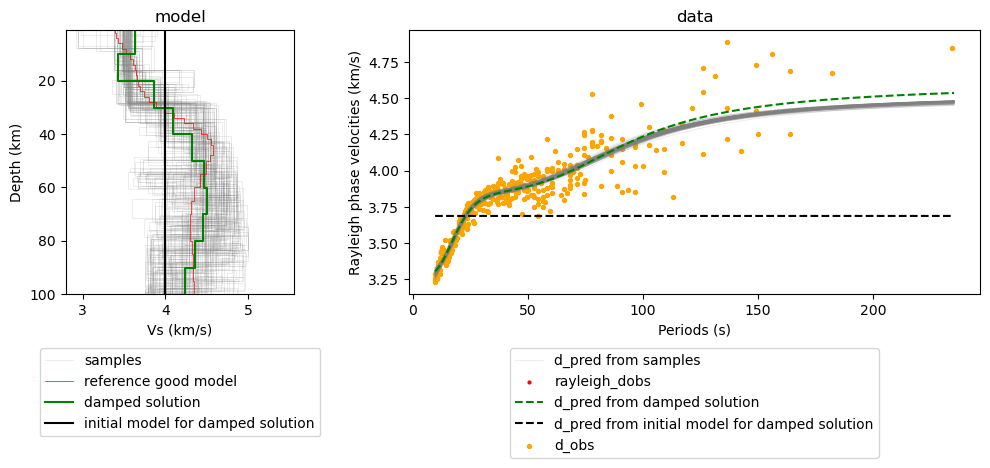

In [84]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

# plot samples and their predicted data
for sample in samples:
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_data(forward_sw_interp(sample, field_d_periods_logspace), field_d_periods_logspace, 
              ax=ax2, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
plot_model(samples[0], ax=ax1, label="samples", alpha=0.2, lw=0.5, color="gray")
plot_data(forward_sw_interp(samples[0], field_d_periods_logspace), field_d_periods_logspace, 
          ax=ax2, alpha=0.2, lw=0.5, color="gray", label="d_pred from samples")

# plot reference good model and data observations
plot_model(ref_good_model, ax=ax1, alpha=1, color="r", label="reference good model")
plot_data(field_d_obs, field_d_periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")

# plot the optmisation result
plot_model(inv_result_sw_field.model, ax=ax1, alpha=1, lw=1.5, color="green", 
           label="damped solution")
plot_data(forward_sw_interp(inv_result_sw_field.model, field_d_periods_logspace), 
          field_d_periods_logspace, ax=ax2, alpha=1, lw=1.5, linestyle="--", color="green", 
          label="d_pred from damped solution")

# plot the initial model for the optimisation
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", 
           label="initial model for damped solution")
plot_data(forward_sw_interp(init_model, field_d_periods_logspace), field_d_periods_logspace, 
          ax=ax2, alpha=1, lw=1.5, linestyle="--", color="black", 
          label="d_pred from initial model for damped solution")

# plot the data observations
plot_data(field_d_obs, field_d_periods, ax=ax2, color="orange", s=8, scatter=True, 
          label="d_obs")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
plt.tight_layout()

---
## Watermark

In [85]:
watermark_list = ["cofi", "numpy", "matplotlib", "scipy", "emcee", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.23.5
matplotlib 3.7.1
scipy 1.10.1
emcee 3.1.4
bayesbay 0.3.0
